# Задание 5
## Повторить эксперимент с оптимизацией функции "Expected Improvement per second" для выбора оптимальных параметров. Выборка: CIFAR-10.

In [95]:
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [96]:
def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y



def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=10,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  model.compile(
           optimizer=K.optimizers.Adam(learning_rate=learning_rate),
           loss='categorical_crossentropy',
           metrics=['accuracy'])

  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')

  checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint


def fit_model(model, lr_reduce, early_stop, checkpoint):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=1024,
                      epochs=20,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

### Датасет и обработка

In [97]:
# load the Cifar10 dataset, 50,000 training images
# and 10,000 test images (here used as validation data)
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
(x_train, y_train), (x_test, y_test) = (x_train[:10000,:,:,:], y_train[:10000,:]), (x_test[:2000,:,:,:], y_test[:2000,:])
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

### Сверточная сеть для настройки параметров - DenseNet

In [98]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network
# was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)

base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=1000)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [99]:
%%time
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=1024,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
val_datagen = K.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=1024,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

CPU times: user 1min 58s, sys: 107 ms, total: 1min 58s
Wall time: 2min 5s


### Параметры для байесовской оптимизации

In [100]:

kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256)}, 
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)}, 
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)}, 
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):

  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('cifar10_best.h5')
    previous_evaluation = (previous_best_model.evaluate(features_valid, y_test))
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint)
  evaluation = model.evaluate(features_valid, y_test)
  print()

  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'cifar10_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each
  # epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
    """function that plots the model loss and accuracy"""
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('EI')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]


63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.07850, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.07850 to 0.08850, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.08850 to 0.09700, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.09700 to 0.11050, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.11050 to 0.12050, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.12050 to 0.12950, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.12950 to 0.14200, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.14200 to 0.15550, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.15550 to 0.16400, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.16400 to 0.17650, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.17650 to 0.19150, saving model to c

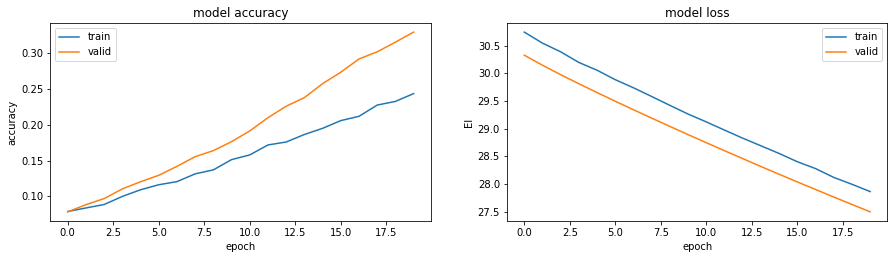

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.08750, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.08750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08750

Epoch 4: val_accuracy did not improve from 0.08750
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 5.8665 - accuracy: 0.0855

[5.866536617279053, 0.08550000190734863]



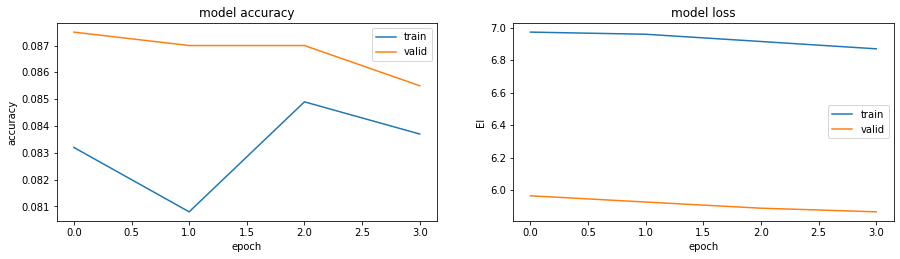

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.58000, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.58000 to 0.73750, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.73750 to 0.79000, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.79000 to 0.82150, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.82150 to 0.82850, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.82850 to 0.84300, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.84300 to 0.85150, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.85150 to 0.85400, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.85400 to 0.85750, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.85750

Epoch 11: val_accuracy improved from 0.85750 to 0.86450, saving model to cifar10.h5

Epoch 12: val_accurac

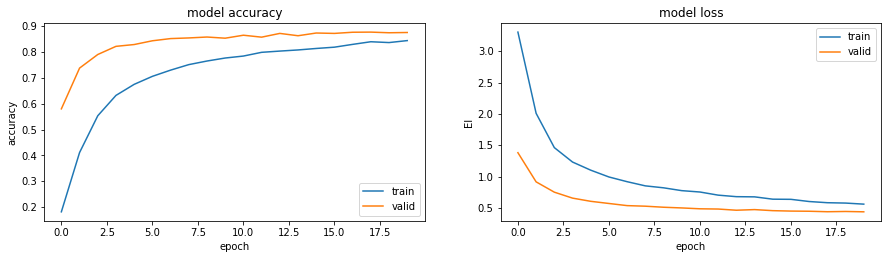

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.09050, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.09050

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.09050

Epoch 4: val_accuracy did not improve from 0.09050
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 12.6834 - accuracy: 0.0895

[12.683418273925781, 0.08950000256299973]



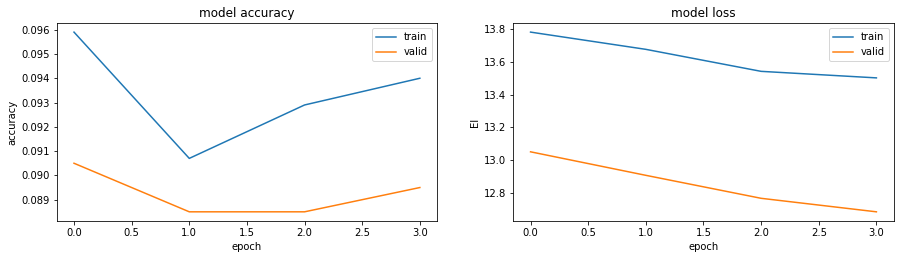

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11700, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.11700 to 0.11950, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.11950 to 0.13200, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.13200 to 0.14300, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.14300 to 0.15050, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.15050 to 0.16000, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.16000 to 0.17550, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.17550 to 0.18750, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.18750 to 0.20450, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.20450 to 0.21800, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.21800 to 0.23650, saving model to c

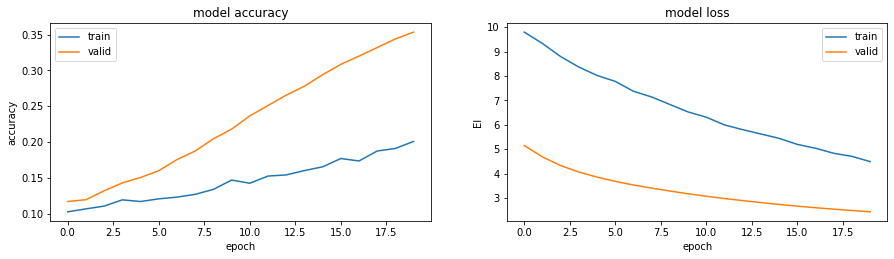



63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.24950, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.24950 to 0.34150, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.34150 to 0.51800, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.51800 to 0.59750, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.59750 to 0.66650, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.66650 to 0.72150, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.72150 to 0.76300, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.76300 to 0.79100, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.79100 to 0.81500, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.81500 to 0.82750, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.82750 to 0.83500, saving model to

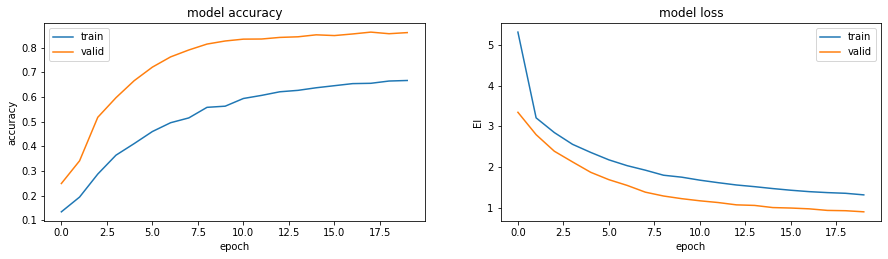

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11100, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.11100

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.11100

Epoch 4: val_accuracy did not improve from 0.11100
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 5.0448 - accuracy: 0.1045

[5.044845104217529, 0.10450000315904617]



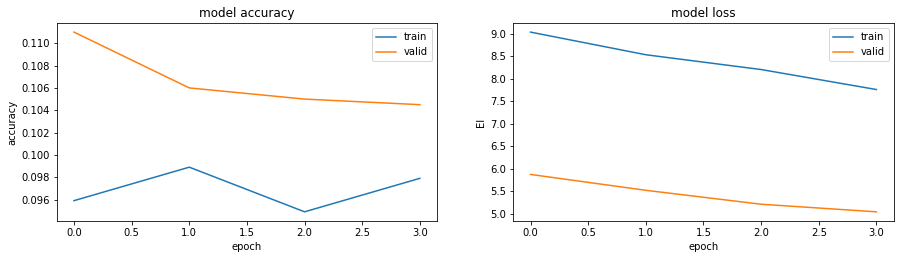

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.08350, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.08350

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08350

Epoch 4: val_accuracy did not improve from 0.08350
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 20.0740 - accuracy: 0.0835

[20.074007034301758, 0.08349999785423279]



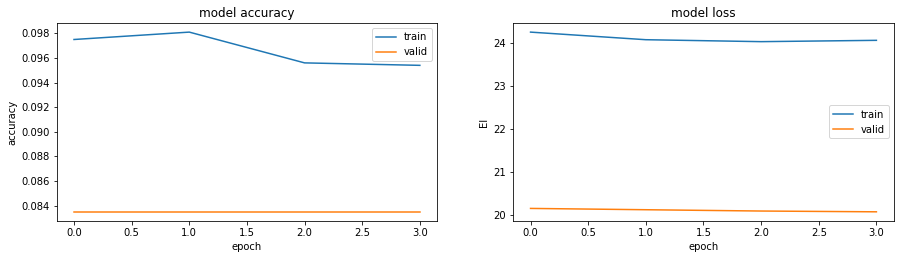

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11100, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.11100 to 0.13300, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.13300 to 0.15050, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.15050 to 0.16050, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.16050 to 0.18250, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.18250 to 0.20750, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.20750 to 0.22750, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.22750 to 0.25400, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.25400 to 0.27900, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.27900 to 0.31900, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.31900 to 0.34700, saving model to c

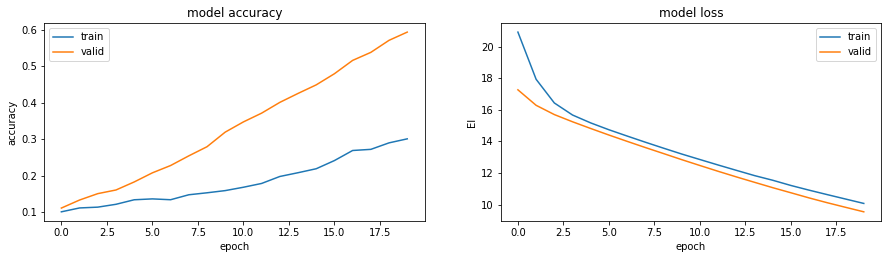

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.07350, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.07350

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.07350

Epoch 4: val_accuracy did not improve from 0.07350
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 5.1191 - accuracy: 0.0725

[5.119062900543213, 0.07249999791383743]



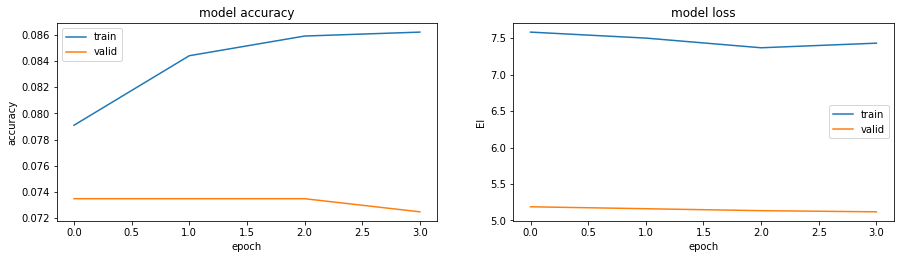

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.12550, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.12550 to 0.12600, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.12600

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 4: val_accuracy did not improve from 0.12600

Epoch 5: val_accuracy did not improve from 0.12600
Epoch 5: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 17.8192 - accuracy: 0.1245

[17.81916046142578, 0.12449999898672104]



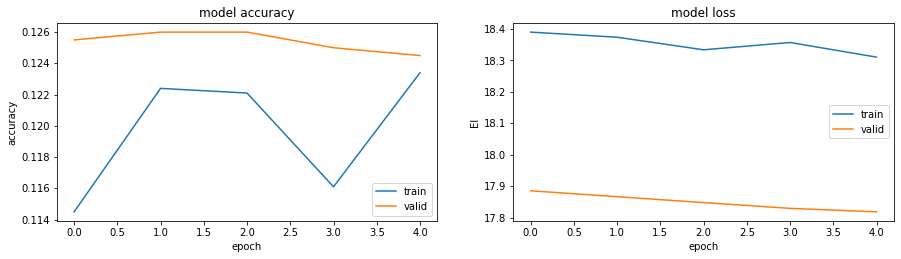

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.08250, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.08250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08250

Epoch 4: val_accuracy improved from 0.08250 to 0.08350, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.08350 to 0.08400, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.08400

Epoch 7: ReduceLROnPlateau reducing learning rate to 3.600000127335079e-07.

Epoch 7: val_accuracy did not improve from 0.08400

Epoch 8: val_accuracy improved from 0.08400 to 0.08500, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.08500

Epoch 10: val_accuracy improved from 0.08500 to 0.08600, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.08600 to 0.08700, saving model to cifar10

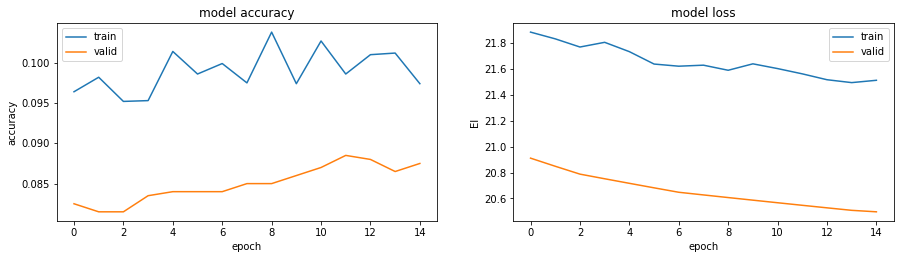

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.08650, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.08650 to 0.09100, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.09100 to 0.09450, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.09450 to 0.09750, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.09750 to 0.10500, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.10500 to 0.11400, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.11400 to 0.11800, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.11800 to 0.12050, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.12050 to 0.12950, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.12950 to 0.13750, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.13750 to 0.14600, saving model to c

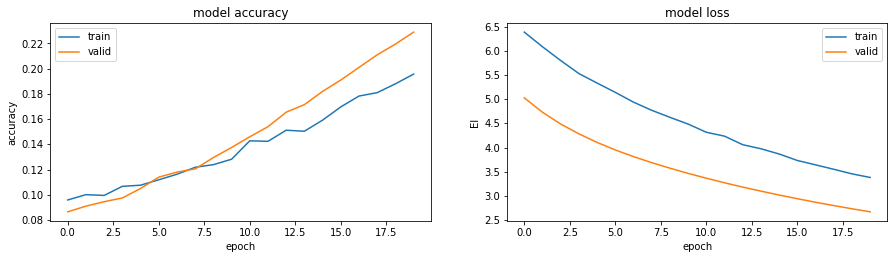

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.05400, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.05400 to 0.05500, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.05500

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 4: val_accuracy did not improve from 0.05500

Epoch 5: val_accuracy did not improve from 0.05500
Epoch 5: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 6.4669 - accuracy: 0.0550

[6.46694278717041, 0.054999999701976776]



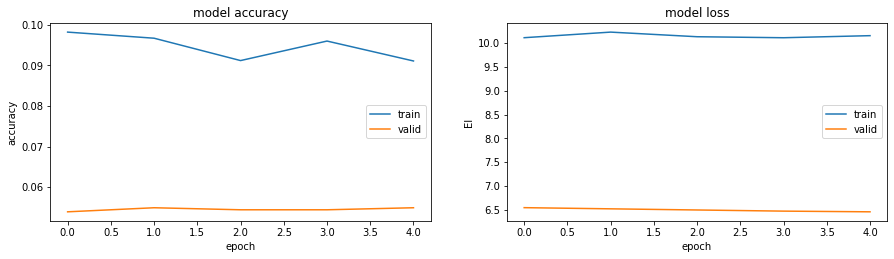

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.09450, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.09450 to 0.12450, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.12450 to 0.17050, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.17050 to 0.25000, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.25000 to 0.33250, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.33250 to 0.38450, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.38450 to 0.44000, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.44000 to 0.48950, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.48950 to 0.52850, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.52850 to 0.56850, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.56850 to 0.60000, saving model to c

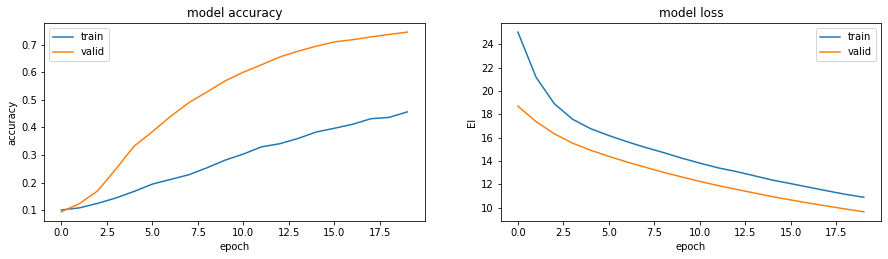

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10250, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10250 to 0.10300, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.10300

Epoch 4: val_accuracy improved from 0.10300 to 0.10350, saving model to cifar10.h5

Epoch 5: val_accuracy did not improve from 0.10350

Epoch 6: val_accuracy improved from 0.10350 to 0.10400, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.10400 to 0.10450, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.10450 to 0.10500, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.10500 to 0.10550, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.10550

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 11: val_accuracy did not improve from 0.10550

Epoch 12: val_accuracy did not improve 

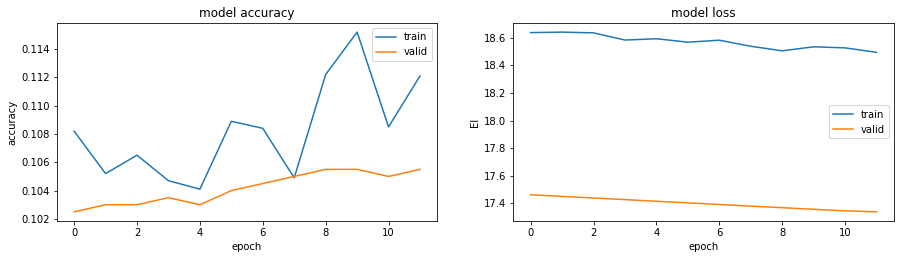

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.12550, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.12550 to 0.13650, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.13650 to 0.14650, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.14650 to 0.15550, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.15550 to 0.16950, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.16950 to 0.17950, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.17950 to 0.19000, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.19000 to 0.19800, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.19800 to 0.20650, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.20650 to 0.21550, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.21550 to 0.22500, saving model to c

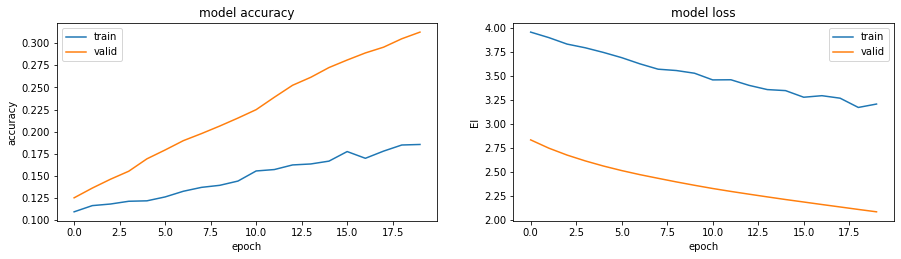

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11700, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.11700 to 0.11800, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.11800 to 0.11850, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.11850

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.11850

Epoch 6: val_accuracy did not improve from 0.11850
Epoch 6: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 6.3261 - accuracy: 0.1175

[6.326136589050293, 0.11749999970197678]



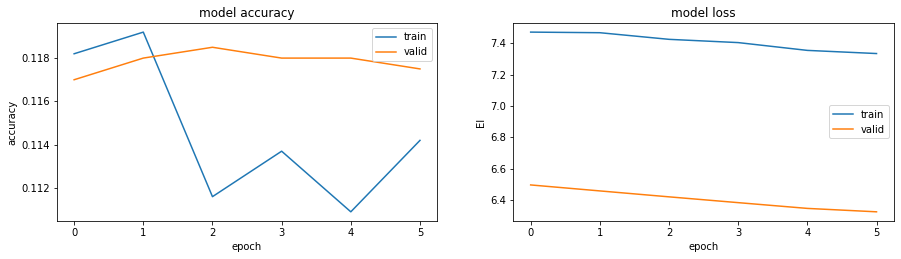

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.13850, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.13850 to 0.25900, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.25900 to 0.35750, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.35750 to 0.44150, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.44150 to 0.50450, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.50450 to 0.56550, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.56550 to 0.61950, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.61950 to 0.64700, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.64700 to 0.67900, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.67900 to 0.69900, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.69900 to 0.72800, saving model to c

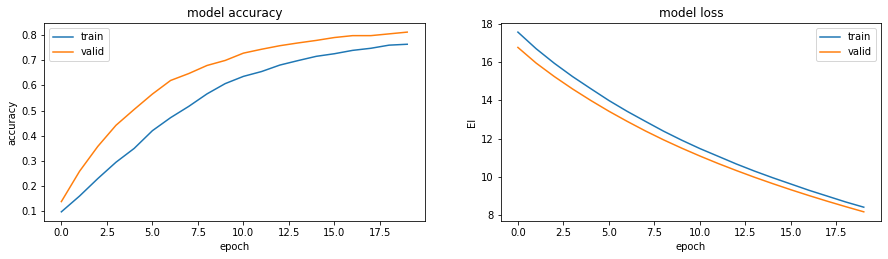

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.12550, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.12550

Epoch 3: val_accuracy improved from 0.12550 to 0.12600, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.12600

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.12600

Epoch 6: val_accuracy did not improve from 0.12600
Epoch 6: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 20.0441 - accuracy: 0.1255

[20.044143676757812, 0.12549999356269836]



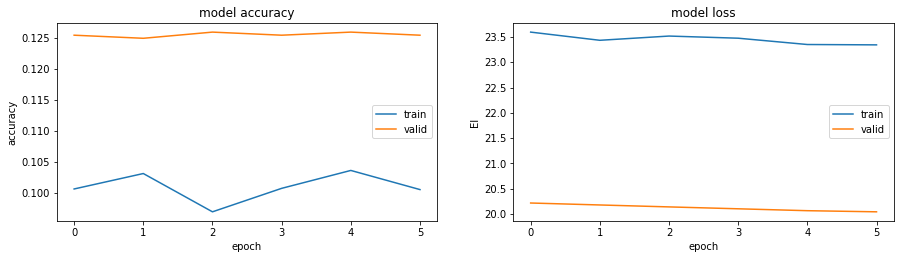

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.45100, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.45100 to 0.65850, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.65850 to 0.73450, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.73450 to 0.78000, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.78000 to 0.80800, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.80800 to 0.82350, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.82350 to 0.84000, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.84000 to 0.84450, saving model to cifar10.h5

Epoch 9: val_accuracy did not improve from 0.84450

Epoch 10: val_accuracy improved from 0.84450 to 0.84550, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.84550 to 0.85600, saving model to cifar10.h5

Epoch 12: val_accurac

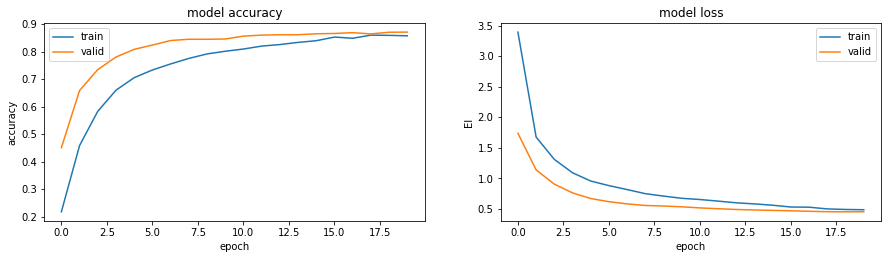

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10850, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10850 to 0.11200, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.11200 to 0.11600, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.11600 to 0.12200, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.12200 to 0.13250, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.13250 to 0.13600, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.13600 to 0.13950, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.13950 to 0.14550, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.14550 to 0.15100, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.15100 to 0.15650, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.15650 to 0.15900, saving model to c

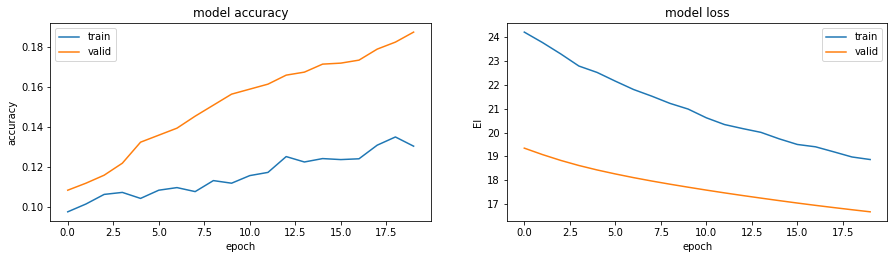

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11950, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.11950 to 0.17100, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.17100 to 0.21450, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.21450 to 0.30350, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.30350 to 0.38500, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.38500 to 0.44650, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.44650 to 0.49600, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.49600 to 0.53850, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.53850 to 0.57600, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.57600 to 0.60650, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.60650 to 0.63400, saving model to c

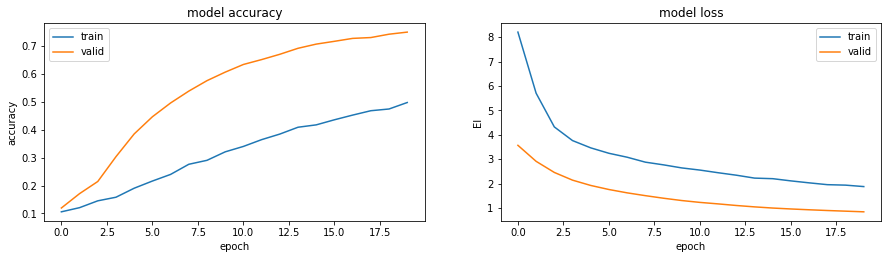

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10700, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10700 to 0.10800, saving model to cifar10.h5

Epoch 3: val_accuracy did not improve from 0.10800

Epoch 4: val_accuracy improved from 0.10800 to 0.10850, saving model to cifar10.h5

Epoch 5: val_accuracy did not improve from 0.10850

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 6: val_accuracy did not improve from 0.10850

Epoch 7: val_accuracy did not improve from 0.10850
Epoch 7: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 6.9927 - accuracy: 0.1080

[6.992709159851074, 0.1080000028014183]



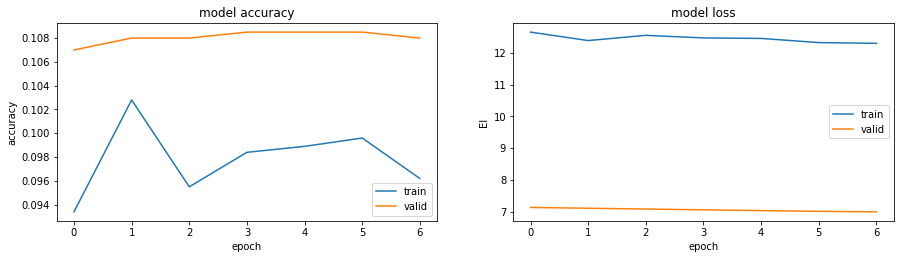

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11400, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.11400

Epoch 3: val_accuracy improved from 0.11400 to 0.11450, saving model to cifar10.h5

Epoch 4: val_accuracy did not improve from 0.11450

Epoch 5: val_accuracy improved from 0.11450 to 0.11550, saving model to cifar10.h5

Epoch 6: val_accuracy did not improve from 0.11550

Epoch 7: val_accuracy improved from 0.11550 to 0.11650, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.11650

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 9: val_accuracy did not improve from 0.11650

Epoch 10: val_accuracy did not improve from 0.11650
Epoch 10: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 17.4436 - accuracy: 0.1165

[17.443578720092773, 0.11649999767541885]



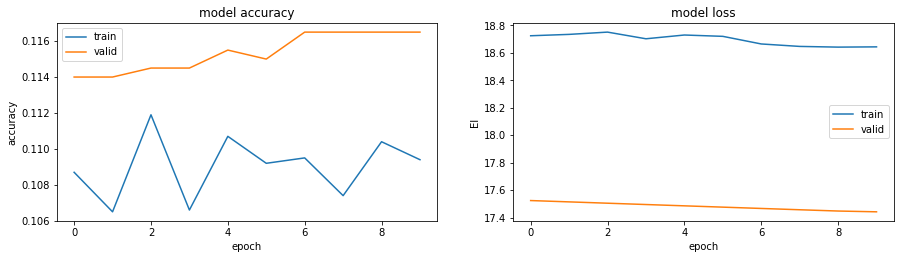

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10550, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10550 to 0.10800, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.10800 to 0.11450, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.11450 to 0.12050, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.12050 to 0.12400, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.12400 to 0.12850, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.12850 to 0.13650, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.13650 to 0.14100, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.14100 to 0.14450, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.14450 to 0.15200, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.15200 to 0.15350, saving model to c

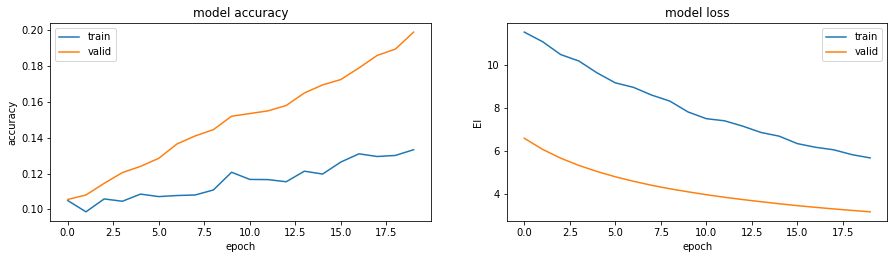

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10150, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10150 to 0.17850, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.17850 to 0.26300, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.26300 to 0.35450, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.35450 to 0.42200, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.42200 to 0.48650, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.48650 to 0.53650, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.53650 to 0.57600, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.57600 to 0.60650, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.60650 to 0.63700, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.63700 to 0.66000, saving model to c

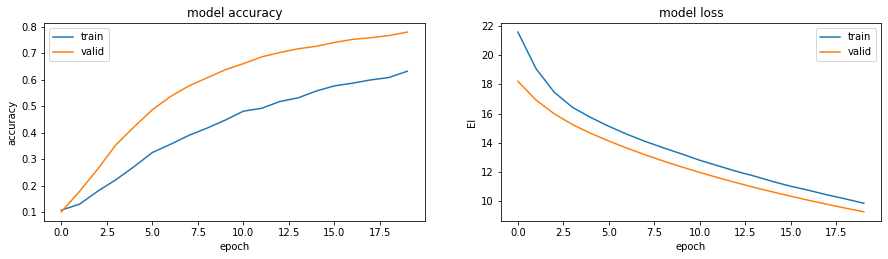

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.60900, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.60900 to 0.75850, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.75850 to 0.81450, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.81450 to 0.83700, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.83700 to 0.84850, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.84850 to 0.85950, saving model to cifar10.h5

Epoch 7: val_accuracy did not improve from 0.85950

Epoch 8: val_accuracy improved from 0.85950 to 0.87300, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.87300 to 0.87800, saving model to cifar10.h5

Epoch 10: val_accuracy did not improve from 0.87800

Epoch 11: val_accuracy improved from 0.87800 to 0.87900, saving model to cifar10.h5

Epoch 12: val_accuracy did not improve from 0.87900



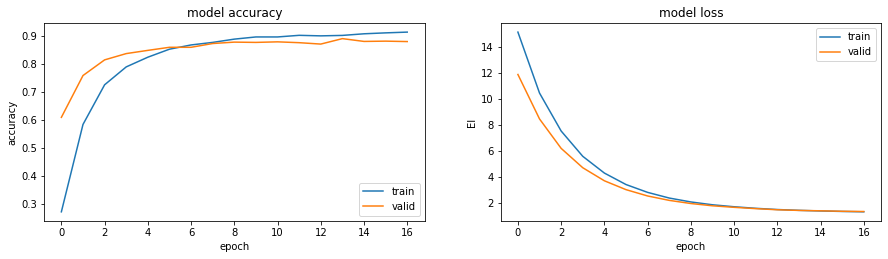

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.62600, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.62600 to 0.76950, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.76950 to 0.80350, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.80350 to 0.83600, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.83600 to 0.84600, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.84600 to 0.85100, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.85100 to 0.85350, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.85350 to 0.86700, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.86700 to 0.86850, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.86850 to 0.87200, saving model to cifar10.h5

Epoch 11: val_accuracy did not improve from 0.87200

Epoch 12: ReduceLROnP

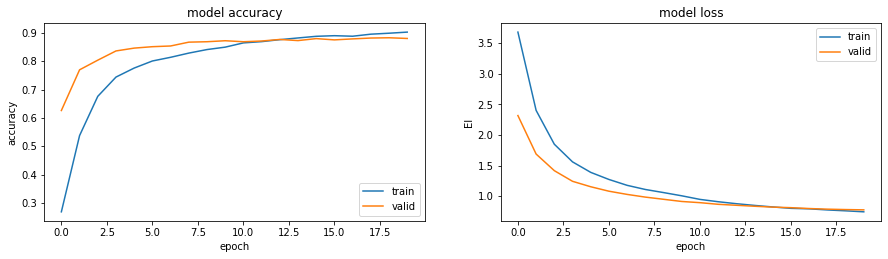

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.10600, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.10600 to 0.10900, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.10900 to 0.11150, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.11150 to 0.11550, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.11550 to 0.11950, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.11950 to 0.12250, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.12250 to 0.12700, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.12700 to 0.13150, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.13150 to 0.13750, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.13750 to 0.14050, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.14050 to 0.14400, saving model to c

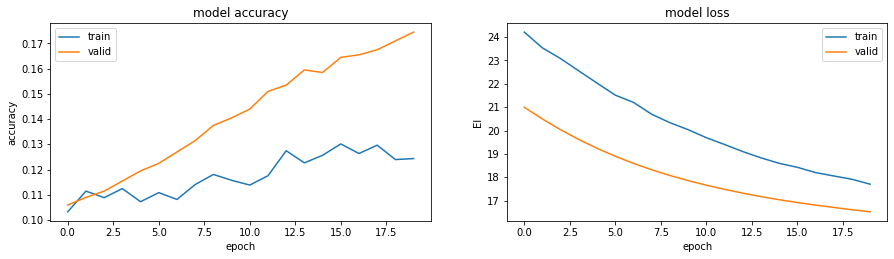

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.13100, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.13100 to 0.21500, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.21500 to 0.31650, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.31650 to 0.40350, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.40350 to 0.46750, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.46750 to 0.52900, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.52900 to 0.58000, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.58000 to 0.61900, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.61900 to 0.64900, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.64900 to 0.67250, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.67250 to 0.69250, saving model to c

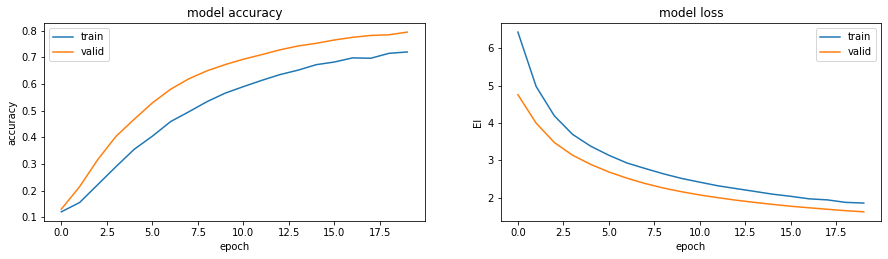

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.60550, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.60550 to 0.77150, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.77150 to 0.81000, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.81000 to 0.84000, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.84000 to 0.84650, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.84650 to 0.85250, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.85250 to 0.86600, saving model to cifar10.h5

Epoch 8: val_accuracy did not improve from 0.86600

Epoch 9: val_accuracy improved from 0.86600 to 0.87450, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.87450 to 0.87550, saving model to cifar10.h5

Epoch 11: val_accuracy did not improve from 0.87550

Epoch 12: val_accuracy improved from 0.87550 to 0.878

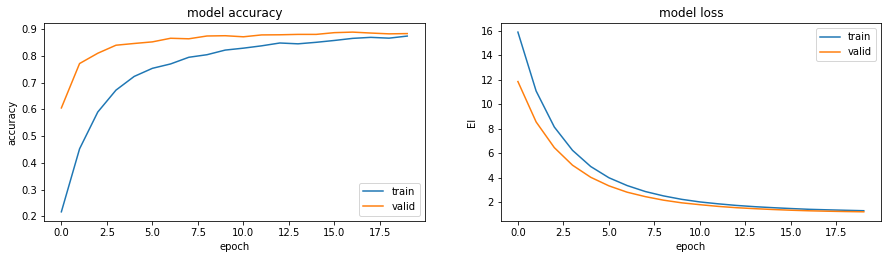

63/63 [==============================] - 0s 4ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.14100, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.14100 to 0.19250, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.19250 to 0.24350, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.24350 to 0.28200, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.28200 to 0.32300, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.32300 to 0.37500, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.37500 to 0.42550, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.42550 to 0.46850, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.46850 to 0.51050, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.51050 to 0.54950, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.54950 to 0.57500, saving model to c

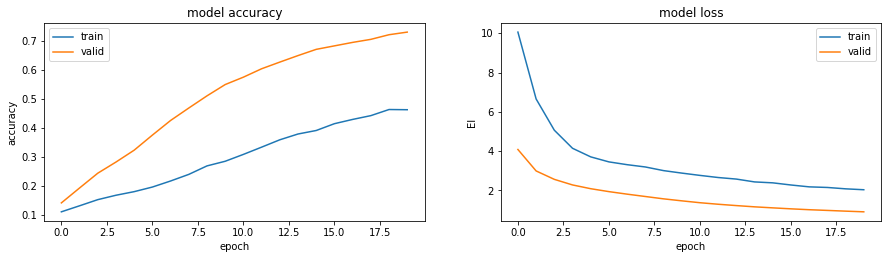

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.09800, saving model to cifar10.h5

Epoch 2: val_accuracy did not improve from 0.09800

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.09800

Epoch 4: val_accuracy did not improve from 0.09800
Epoch 4: early stopping
63/63 [==============================] - 0s 4ms/step - loss: 3.1974 - accuracy: 0.0940

[3.197364091873169, 0.09399999678134918]



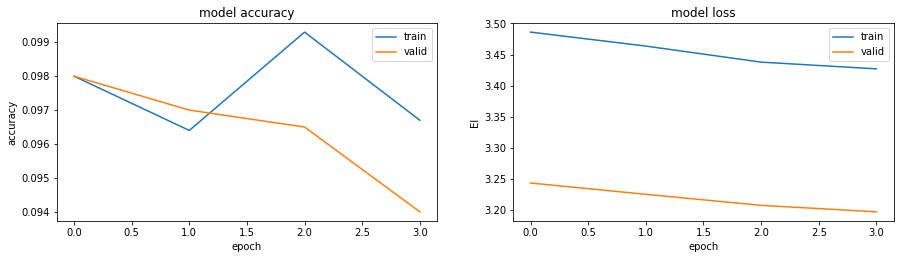

63/63 [==============================] - 0s 5ms/step - loss: 0.9383 - accuracy: 0.8945

Epoch 1: val_accuracy improved from -inf to 0.11600, saving model to cifar10.h5

Epoch 2: val_accuracy improved from 0.11600 to 0.17800, saving model to cifar10.h5

Epoch 3: val_accuracy improved from 0.17800 to 0.22150, saving model to cifar10.h5

Epoch 4: val_accuracy improved from 0.22150 to 0.27100, saving model to cifar10.h5

Epoch 5: val_accuracy improved from 0.27100 to 0.33800, saving model to cifar10.h5

Epoch 6: val_accuracy improved from 0.33800 to 0.39200, saving model to cifar10.h5

Epoch 7: val_accuracy improved from 0.39200 to 0.43650, saving model to cifar10.h5

Epoch 8: val_accuracy improved from 0.43650 to 0.48700, saving model to cifar10.h5

Epoch 9: val_accuracy improved from 0.48700 to 0.53650, saving model to cifar10.h5

Epoch 10: val_accuracy improved from 0.53650 to 0.57100, saving model to cifar10.h5

Epoch 11: val_accuracy improved from 0.57100 to 0.60350, saving model to c

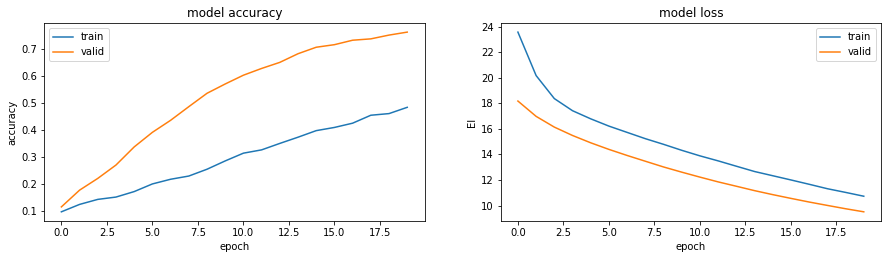

CPU times: user 2min 35s, sys: 20.5 s, total: 2min 56s
Wall time: 2min 58s


In [101]:
%%time

optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
   
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=30, verbosity=False)

### Таким образом временные затраты на обучение одной базовой модели и на оптимизацию параметров получились соответственно: 
 ### **2min 5s и 2min 58s.**
### То есть оптимизация нескольких значений параметров не превышает двойного времени обучения базовой модели, что является хорошим показателем ее эффективности